In [2]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import timm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score

class Config:
    BASE_PATH = "/kaggle/input/rsna-intracranial-aneurysm-detection"
    CSV_PATH = os.path.join(BASE_PATH, "train.csv")
    IMAGE_DIR = os.path.join(BASE_PATH, "series")
    
    # Saving as Binary Model
    SAVE_PATH = "best_binary_mra_model.pth"
    
    # BINARY LABEL ONLY
    LABEL_COLS = ['Aneurysm Present']
    
    MODEL_NAME = 'swin_tiny_patch4_window7_224' 
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 16
    EPOCHS = 10 
    LR = 5e-5
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"✅ Configuration Ready. Device: {Config.DEVICE}")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Configuration Ready. Device: cuda


In [3]:
def process_mra_binary_series(row, image_dir, label_cols):
    """
    Worker function: Checks if series is MRA, then extracts 
    paths for binary classification.
    """
    sid = row['SeriesInstanceUID']
    # Extract just the binary label (0 or 1)
    # The CSV might have many columns, we only grabbed ['Aneurysm Present'] in Config
    labels = row[label_cols].values.astype(np.float32)
    
    series_path = os.path.join(image_dir, str(sid))
    if not os.path.exists(series_path): return []
    
    try:
        dir_files = [f for f in os.listdir(series_path) if f.endswith('.dcm')]
        if not dir_files: return []
        
        # 1. Check Modality (Must be MR)
        first = pydicom.dcmread(os.path.join(series_path, dir_files[0]), stop_before_pixels=True)
        if "MR" not in getattr(first, "Modality", ""): return []

        # 2. Get all slices
        files = []
        for f in dir_files:
            p = os.path.join(series_path, f)
            d = pydicom.dcmread(p, stop_before_pixels=True)
            files.append((int(d.InstanceNumber), p))
            
        if len(files) < 3: return []
        files.sort(key=lambda x: x[0])
        paths = [f[1] for f in files]
        n_slices = len(paths)
        
        # 3. Smart Sampling
        # Positive (1) -> 5 Slices
        # Negative (0) -> 1 Slice (Center)
        samples = []
        if labels[0] == 1: 
            indices = np.linspace(0, n_slices - 1, num=5).astype(int)
            indices = np.unique(indices)
        else:
            indices = [n_slices // 2]

        for c_idx in indices:
            samples.append({'paths': paths, 'center_idx': c_idx, 'labels': labels})
        return samples
    except: return []

class BinaryMRADataset(Dataset):
    def __init__(self, df):
        print(f"⚡ Indexing {len(df)} series (Filtering MRA)...")
        results = Parallel(n_jobs=4, backend="threading")(
            delayed(process_mra_binary_series)(row, Config.IMAGE_DIR, Config.LABEL_COLS) 
            for _, row in tqdm(df.iterrows(), total=len(df))
        )
        self.samples = [item for sublist in results for item in sublist]
        print(f"✅ Found {len(self.samples)} valid samples.")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        imgs = []
        for d in (-1, 0, 1):
            k = np.clip(item['center_idx'] + d, 0, len(item['paths']) - 1)
            try:
                ds = pydicom.dcmread(item['paths'][k], stop_before_pixels=False)
                img = ds.pixel_array.astype(np.float32)
                c, w = 100, 200 # MRA Window
                img = np.clip(img, c - w/2, c + w/2)
                img = (img - (c - w/2)) / w
                img = cv2.resize(img, Config.IMG_SIZE)
            except: img = np.zeros(Config.IMG_SIZE, dtype=np.float32)
            imgs.append(img)
        return torch.tensor(np.stack(imgs), dtype=torch.float32), torch.tensor(item['labels'], dtype=torch.float32)

In [4]:
class RSNABinaryViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(Config.MODEL_NAME, pretrained=True, in_chans=3, num_classes=0)
        dim = self.backbone.num_features if hasattr(self.backbone, 'num_features') else self.backbone.embed_dim
        
        # Single output neuron for Binary Classification
        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Dropout(0.3),
            nn.Linear(dim, 1) 
        )
        
    def forward(self, x): return self.head(self.backbone(x))

In [5]:
def train_binary_3split_clean():
    print("🔍 Loading & Analyzing MRA Data...")
    df = pd.read_csv(Config.CSV_PATH)
    
    # 1. Filter MRA
    meta_path = os.path.join(Config.BASE_PATH, "train_series_metadata.csv")
    if os.path.exists(meta_path):
        meta = pd.read_csv(meta_path)
        df = df.merge(meta[['SeriesInstanceUID', 'Modality']], on="SeriesInstanceUID", how="left")
        df = df[df['Modality'] == 'MRA'].reset_index(drop=True)
    
    # 2. Index Dataset
    full_ds = BinaryMRADataset(df)
    if len(full_ds) == 0: return None, None

    # 3. Stratified Split
    all_labels = [int(x['labels'][0]) for x in full_ds.samples]
    indices = np.arange(len(full_ds))
    
    # Split 80/10/10
    train_idx, temp_idx, y_train, y_temp = train_test_split(indices, all_labels, stratify=all_labels, test_size=0.2, random_state=42)
    val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, stratify=y_temp, test_size=0.5, random_state=42)
    
    # 4. PRINT DATA STATISTICS
    print("\n" + "="*50)
    print("📊 DATASET DISTRIBUTION REPORT")
    print("="*50)
    print(f"{'SPLIT':<10} | {'TOTAL':<8} | {'HEALTHY (0)':<12} | {'SICK (1)':<12} | {'RATIO'}")
    print("-" * 65)
    
    def print_stat(name, y_data):
        c = np.bincount(y_data)
        n0, n1 = c[0], c[1]
        print(f"{name:<10} | {len(y_data):<8} | {n0:<12} | {n1:<12} | 1:{n0/n1:.1f}")
        return n0, n1

    n0_train, n1_train = print_stat("TRAIN", y_train)
    print_stat("VALIDATION", y_val)
    print_stat("TEST", y_test)
    print("-" * 65)

    # 5. Sampler (Balanced Training)
    w0 = 1.0 / n0_train
    w1 = 1.0 / n1_train
    sample_weights = [w1 if t == 1 else w0 for t in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    
    # 6. Loaders
    train_ds = torch.utils.data.Subset(full_ds, train_idx)
    val_ds = torch.utils.data.Subset(full_ds, val_idx)
    test_ds = torch.utils.data.Subset(full_ds, test_idx)
    
    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2)
    
    # 7. Model Setup
    model = RSNABinaryViT().to(Config.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=1e-2)
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.EPOCHS)
    criterion = nn.BCEWithLogitsLoss()
    
    # 8. Clean Training Loop
    best_auc = 0.0
    print(f"\n🚀 Starting Training ({Config.EPOCHS} Epochs)...")
    
    for epoch in range(Config.EPOCHS):
        model.train()
        
        # TQDM Bar
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}", leave=True)
        
        for x, y in pbar:
            x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        scheduler.step()
        
        # Validation
        model.eval()
        y_true, y_probs = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
                logits = model(x)
                y_true.append(y.cpu().numpy())
                y_probs.append(torch.sigmoid(logits).cpu().numpy())
        
        y_true = np.concatenate(y_true)
        y_probs = np.concatenate(y_probs)
        try:
            val_auc = roc_auc_score(y_true, y_probs)
        except: val_auc = 0.5
        
        print(f"   └── Results: Val AUC: {val_auc:.4f} | Best: {max(best_auc, val_auc):.4f}")
        
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save({'state_dict': model.state_dict(), 'config': Config}, Config.SAVE_PATH)

    # Load Best (FIXED LINE BELOW)
    # weights_only=False fixes the UnpicklingError
    ckpt = torch.load(Config.SAVE_PATH, weights_only=False) 
    model.load_state_dict(ckpt['state_dict'])
    print(f"\n✅ Training Complete. Best Model AUC: {best_auc:.4f}")
    
    return model, test_loader

# RUN
model, test_loader = train_binary_3split_clean()

🔍 Loading & Analyzing MRA Data...
⚡ Indexing 4348 series (Filtering MRA)...


100%|██████████| 4348/4348 [13:14<00:00,  5.47it/s]


✅ Found 5210 valid samples.

📊 DATASET DISTRIBUTION REPORT
SPLIT      | TOTAL    | HEALTHY (0)  | SICK (1)     | RATIO
-----------------------------------------------------------------
TRAIN      | 4168     | 1176         | 2992         | 1:0.4
VALIDATION | 521      | 147          | 374          | 1:0.4
TEST       | 521      | 147          | 374          | 1:0.4
-----------------------------------------------------------------


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


🚀 Starting Training (10 Epochs)...


Epoch 1/10: 100%|██████████| 261/261 [01:59<00:00,  2.18it/s, loss=0.1104]


   └── Results: Val AUC: 0.9162 | Best: 0.9162


Epoch 2/10: 100%|██████████| 261/261 [01:53<00:00,  2.30it/s, loss=0.3692]


   └── Results: Val AUC: 0.9168 | Best: 0.9168


Epoch 3/10: 100%|██████████| 261/261 [01:45<00:00,  2.48it/s, loss=0.1100]


   └── Results: Val AUC: 0.9280 | Best: 0.9280


Epoch 4/10: 100%|██████████| 261/261 [01:43<00:00,  2.52it/s, loss=0.0428]


   └── Results: Val AUC: 0.9360 | Best: 0.9360


Epoch 5/10: 100%|██████████| 261/261 [01:41<00:00,  2.57it/s, loss=0.0079]


   └── Results: Val AUC: 0.9296 | Best: 0.9360


Epoch 6/10: 100%|██████████| 261/261 [01:39<00:00,  2.63it/s, loss=0.0138]


   └── Results: Val AUC: 0.9393 | Best: 0.9393


Epoch 7/10: 100%|██████████| 261/261 [01:40<00:00,  2.60it/s, loss=0.0350]


   └── Results: Val AUC: 0.9287 | Best: 0.9393


Epoch 8/10: 100%|██████████| 261/261 [01:42<00:00,  2.55it/s, loss=0.0053]


   └── Results: Val AUC: 0.9344 | Best: 0.9393


Epoch 9/10: 100%|██████████| 261/261 [01:39<00:00,  2.62it/s, loss=0.0080]


   └── Results: Val AUC: 0.9303 | Best: 0.9393


Epoch 10/10: 100%|██████████| 261/261 [01:41<00:00,  2.58it/s, loss=0.0023]


   └── Results: Val AUC: 0.9315 | Best: 0.9393

✅ Training Complete. Best Model AUC: 0.9393


🏥 Running Final Test Evaluation...


100%|██████████| 33/33 [00:15<00:00,  2.09it/s]



FINAL TEST SET RESULTS
AUC Score:   0.9132
Accuracy:    0.8484
F1 Score:    0.8942
Sensitivity: 89.3% (Recall)
Specificity: 73.5%
--------------------
TP: 334 | FN: 40
FP: 39 | TN: 108


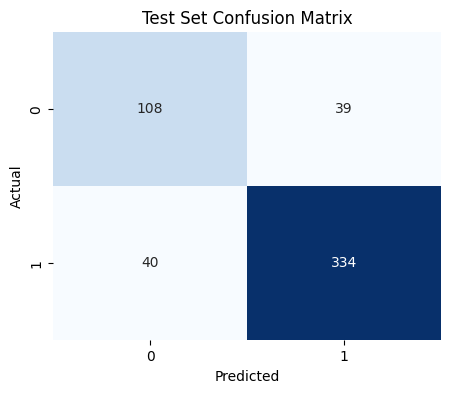

In [6]:
def evaluate_final(model, loader):
    model.eval()
    y_true, y_probs = [], []
    
    print("🏥 Running Final Test Evaluation...")
    with torch.no_grad():
        for x, y in tqdm(loader):
            logits = model(x.to(Config.DEVICE))
            y_true.append(y.cpu().numpy())
            y_probs.append(torch.sigmoid(logits).cpu().numpy())
            
    y_true = np.concatenate(y_true)
    y_probs = np.concatenate(y_probs)
    y_preds = (y_probs > 0.5).astype(int) # Standard threshold
    
    # Metrics
    auc_score = roc_auc_score(y_true, y_probs)
    acc = accuracy_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    
    print("\n" + "="*40)
    print("FINAL TEST SET RESULTS")
    print("="*40)
    print(f"AUC Score:   {auc_score:.4f}")
    print(f"Accuracy:    {acc:.4f}")
    print(f"F1 Score:    {f1:.4f}")
    print(f"Sensitivity: {sens:.1%} (Recall)")
    print(f"Specificity: {spec:.1%}")
    print("-" * 20)
    print(f"TP: {tp} | FN: {fn}")
    print(f"FP: {fp} | TN: {tn}")
    
    plt.figure(figsize=(5,4))
    sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Test Set Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

if test_loader:
    evaluate_final(model, test_loader)

In [7]:
class BinaryScreener:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        ckpt = torch.load(model_path, map_location=device)
        self.cfg = ckpt['config']
        
        self.backbone = timm.create_model(self.cfg.MODEL_NAME, pretrained=False, in_chans=3, num_classes=0)
        dim = self.backbone.num_features if hasattr(self.backbone, 'num_features') else self.backbone.embed_dim
        self.head = nn.Sequential(nn.LayerNorm(dim), nn.Dropout(0.3), nn.Linear(dim, 1))
        
        full = nn.Sequential(self.backbone, self.head)
        
        # Clean keys
        state = {k.replace('backbone.', '0.').replace('head.', '1.'): v for k, v in ckpt['state_dict'].items()}
        full.load_state_dict(state)
        self.model = full.to(device).eval()
        print("✅ Screener Ready.")

    def predict(self, dcm_path):
        try:
            ds = pydicom.dcmread(dcm_path, stop_before_pixels=False)
            img = ds.pixel_array.astype(np.float32)
            c, w = 100, 200
            img = np.clip(img, c - w/2, c + w/2)
            img = (img - (c - w/2)) / w
            img = cv2.resize(img, self.cfg.IMG_SIZE)
            
            stack = np.stack([img, img, img], axis=0)
            t = torch.tensor(stack, dtype=torch.float32).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                prob = torch.sigmoid(self.model(t)).item()
            return f"Probability: {prob:.4f} ({'SICK' if prob>0.5 else 'HEALTHY'})"
        except: return "Error"

# screener = BinaryScreener(Config.SAVE_PATH)
# print(screener.predict("test.dcm"))

📊 Running inference for visualization...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


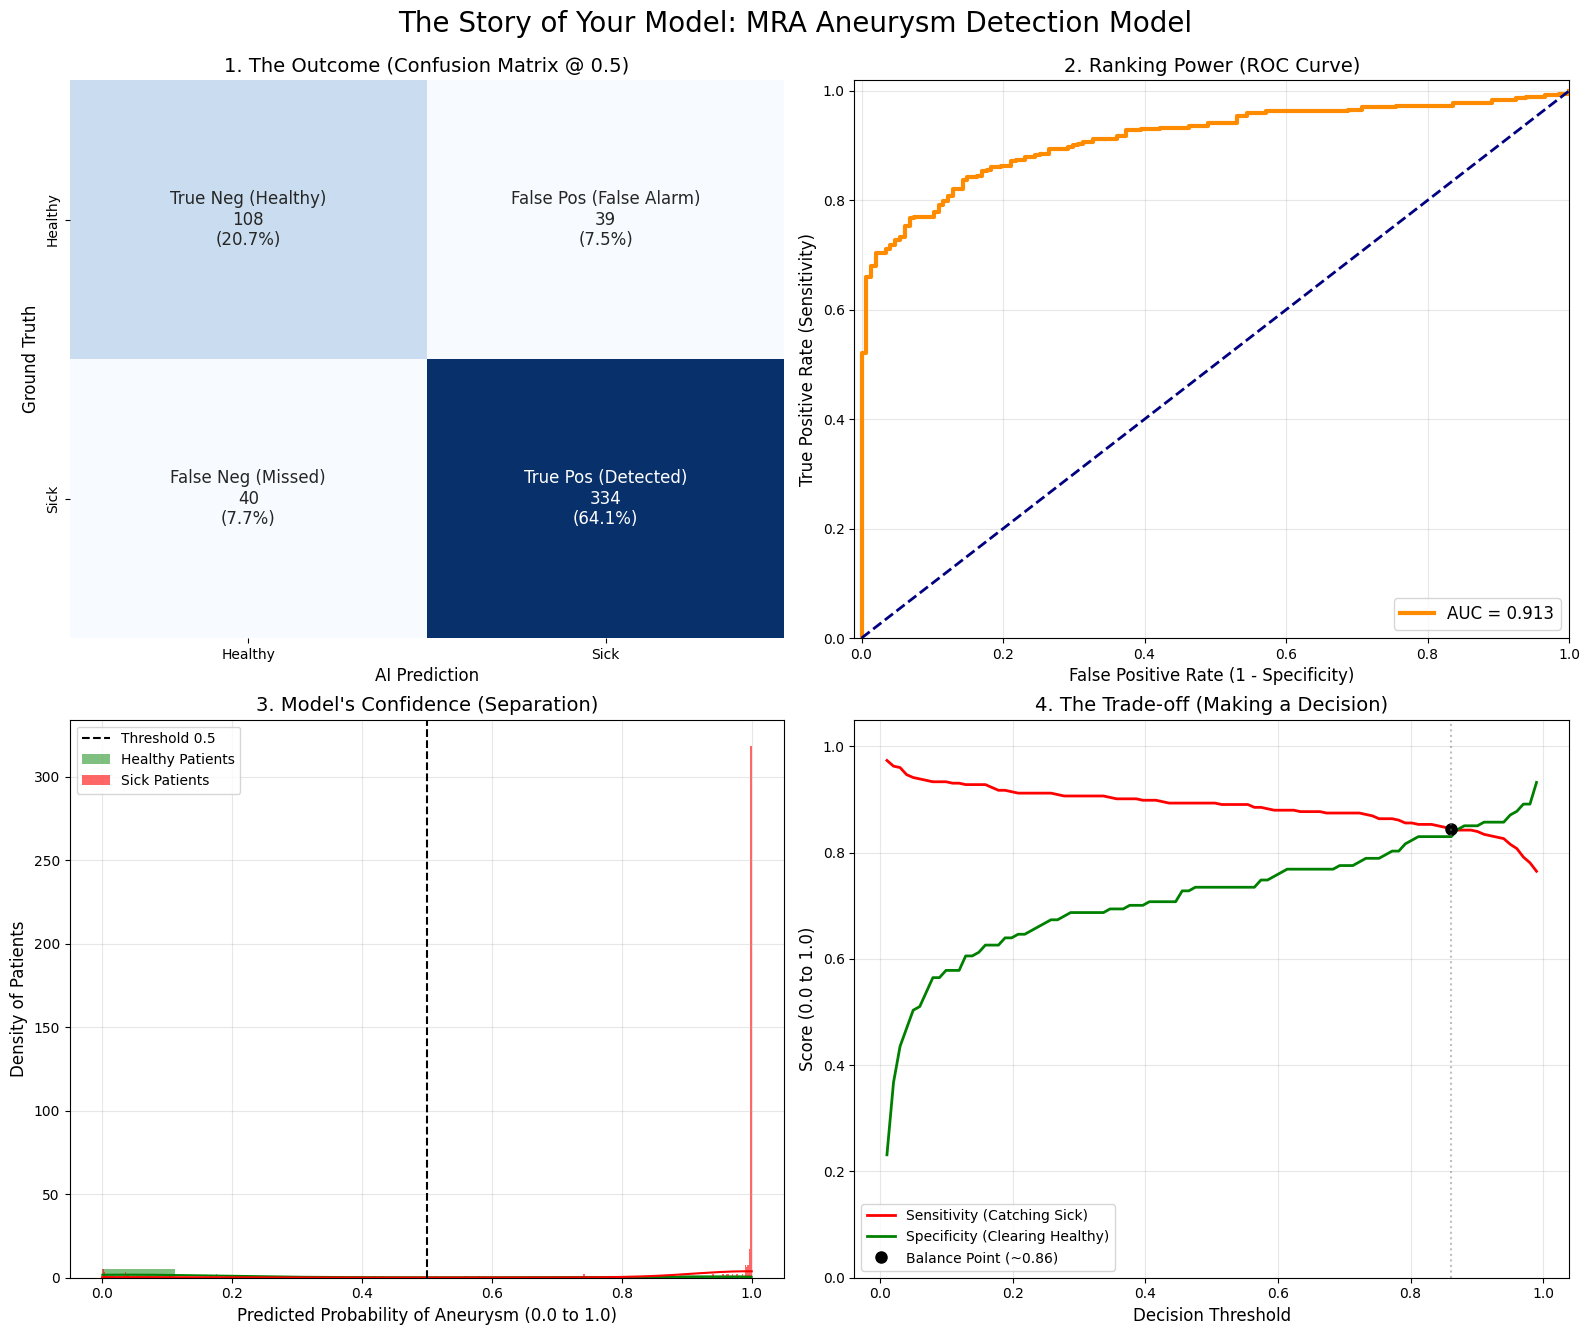


💡 THE STORY INTERPRETATION:
1. Confusion Matrix: Shows the raw results. Look at the top-right (False Positives) vs bottom-right (True Positives).
2. ROC Curve: AUC > 0.90 means the model is excellent at ranking sick patients higher than healthy ones.
3. Confidence Histogram: Ideally, you want a big green peak on the left (0.0) and a big red peak on the right (1.0). Overlap is where errors happen.
4. Trade-off Curve: This is for the doctor. If they want 95% Sensitivity, they can find the threshold on the red line and see what Specificity (green line) they will sacrifice.


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tqdm import tqdm

def visualize_model_story(model, loader, device=Config.DEVICE, title="MRA Aneurysm Detection Model"):
    """
    Generates a 4-panel visualization storyboard explaining model performance.
    """
    model.eval()
    y_true, y_probs = [], []
    
    print("📊 Running inference for visualization...")
    with torch.no_grad():
        for x, y in tqdm(loader, leave=False):
            logits = model(x.to(device))
            y_true.append(y.cpu().numpy())
            y_probs.append(torch.sigmoid(logits).cpu().numpy())
            
    y_true = np.concatenate(y_true).ravel()
    y_probs = np.concatenate(y_probs).ravel()
    
    # Set up the figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    plt.suptitle(f"The Story of Your Model: {title}", fontsize=20, y=0.95)
    
    # ==================================================
    # PANEL 1: Confusion Matrix (At Threshold 0.5)
    # ==================================================
    threshold = 0.5
    y_preds = (y_probs > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    
    labels = [f"True Neg (Healthy)\n{tn}\n({tn/len(y_true):.1%})", 
              f"False Pos (False Alarm)\n{fp}\n({fp/len(y_true):.1%})",
              f"False Neg (Missed)\n{fn}\n({fn/len(y_true):.1%})", 
              f"True Pos (Detected)\n{tp}\n({tp/len(y_true):.1%})"]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap([[tn, fp], [fn, tp]], annot=labels, fmt='', cmap='Blues', ax=axes[0,0], cbar=False, annot_kws={"size": 12})
    axes[0,0].set_title(f"1. The Outcome (Confusion Matrix @ {threshold})", fontsize=14)
    axes[0,0].set_xlabel("AI Prediction", fontsize=12)
    axes[0,0].set_ylabel("Ground Truth", fontsize=12)
    axes[0,0].set_xticklabels(['Healthy', 'Sick'])
    axes[0,0].set_yticklabels(['Healthy', 'Sick'])
    
    # ==================================================
    # PANEL 2: ROC Curve (Ranking Ability)
    # ==================================================
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    axes[0,1].plot(fpr, tpr, color='darkorange', lw=3, label=f'AUC = {roc_auc:.3f}')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,1].set_xlim([-0.01, 1.0])
    axes[0,1].set_ylim([0.0, 1.02])
    axes[0,1].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    axes[0,1].set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    axes[0,1].set_title("2. Ranking Power (ROC Curve)", fontsize=14)
    axes[0,1].legend(loc="lower right", fontsize=12)
    axes[0,1].grid(alpha=0.3)
    
    # ==================================================
    # PANEL 3: Confidence Histogram (Separation)
    # ==================================================
    sns.histplot(y_probs[y_true==0], color='green', label='Healthy Patients', kde=True, ax=axes[1,0], stat="density", linewidth=0)
    sns.histplot(y_probs[y_true==1], color='red', label='Sick Patients', kde=True, ax=axes[1,0], stat="density", linewidth=0, alpha=0.6)
    axes[1,0].axvline(threshold, color='black', linestyle='--', label=f'Threshold {threshold}')
    axes[1,0].set_title("3. Model's Confidence (Separation)", fontsize=14)
    axes[1,0].set_xlabel('Predicted Probability of Aneurysm (0.0 to 1.0)', fontsize=12)
    axes[1,0].set_ylabel('Density of Patients', fontsize=12)
    axes[1,0].legend(fontsize=10)
    axes[1,0].grid(alpha=0.3)
    
    # ==================================================
    # PANEL 4: The Trade-off (Sens vs Spec Curve)
    # ==================================================
    sens, specs = [], []
    thresh_range = np.linspace(0.01, 0.99, 100)
    for t in thresh_range:
        yp = (y_probs > t).astype(int)
        tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_true, yp).ravel()
        sens.append(tp_t / (tp_t + fn_t))
        specs.append(tn_t / (tn_t + fp_t))
        
    axes[1,1].plot(thresh_range, sens, color='red', lw=2, label='Sensitivity (Catching Sick)')
    axes[1,1].plot(thresh_range, specs, color='green', lw=2, label='Specificity (Clearing Healthy)')
    
    # Find intersection (balance point)
    idx = np.argwhere(np.diff(np.sign(np.array(sens) - np.array(specs)))).flatten()
    if len(idx) > 0:
        balance_thresh = thresh_range[idx[0]]
        balance_val = sens[idx[0]]
        axes[1,1].plot(balance_thresh, balance_val, 'ko', markersize=8, label=f'Balance Point (~{balance_thresh:.2f})')
        axes[1,1].axvline(balance_thresh, color='gray', linestyle=':', alpha=0.5)
        
    axes[1,1].set_xlabel('Decision Threshold', fontsize=12)
    axes[1,1].set_ylabel('Score (0.0 to 1.0)', fontsize=12)
    axes[1,1].set_title("4. The Trade-off (Making a Decision)", fontsize=14)
    axes[1,1].set_ylim([0.0, 1.05])
    axes[1,1].legend(fontsize=10)
    axes[1,1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90) # Make room for suptitle
    plt.show()
    
    print("\n💡 THE STORY INTERPRETATION:")
    print("1. Confusion Matrix: Shows the raw results. Look at the top-right (False Positives) vs bottom-right (True Positives).")
    print("2. ROC Curve: AUC > 0.90 means the model is excellent at ranking sick patients higher than healthy ones.")
    print("3. Confidence Histogram: Ideally, you want a big green peak on the left (0.0) and a big red peak on the right (1.0). Overlap is where errors happen.")
    print("4. Trade-off Curve: This is for the doctor. If they want 95% Sensitivity, they can find the threshold on the red line and see what Specificity (green line) they will sacrifice.")

# Run the storyteller on your held-out TEST set
if 'test_loader' in locals() and 'model' in locals():
    visualize_model_story(model, test_loader)
else:
    print("Please run training first to define 'model' and 'test_loader'.")

🔍 Re-loading Full Dataset...
⚡ Indexing 4348 series (Filtering MRA)...


100%|██████████| 4348/4348 [11:34<00:00,  6.26it/s]


✅ Found 5210 valid samples.
📊 Splits Re-created: Train=4168, Test=521

🚀 Evaluating Training Set (Memory)...


🚀 Evaluating Test Set (Generalization)...



METRIC          | TRAIN (Learned)    | TEST (Unseen)      | GAP
AUC Score       | 0.9983             | 0.9132             | +0.085 ✅
Accuracy        | 0.9863             | 0.8484             | +0.138 ⚠️
F1 Score        | 0.9904             | 0.8942             | +0.096 ✅
Sensitivity     | 0.9809             | 0.8930             | +0.088 ✅
Specificity     | 1.0000             | 0.7347             | +0.265 ⚠️
----------------------------------------------------------------------


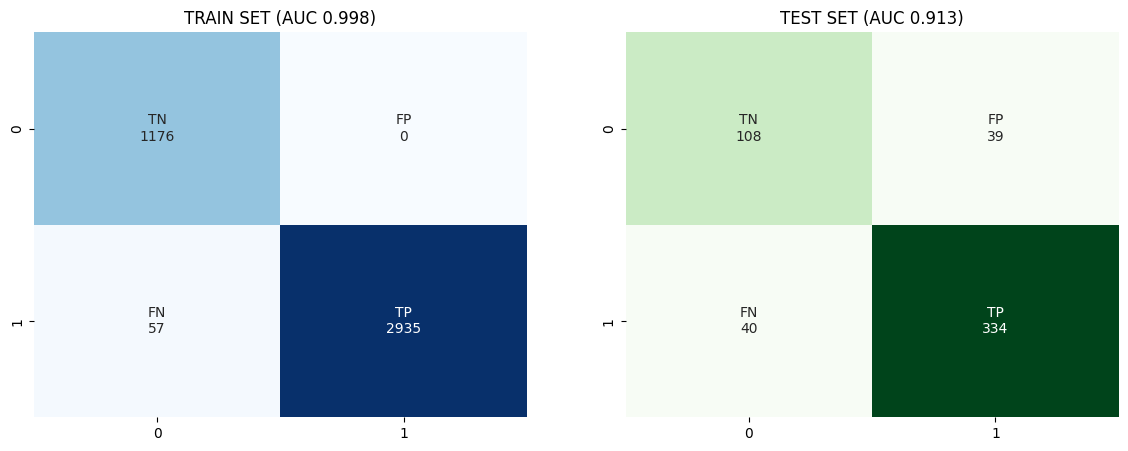

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import os
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# ==========================================
# 1. RE-CREATE THE EXACT SPLITS
# ==========================================
def get_all_loaders():
    print("🔍 Re-loading Full Dataset...")
    df = pd.read_csv(Config.CSV_PATH)
    
    # Filter MRA
    meta_path = os.path.join(Config.BASE_PATH, "train_series_metadata.csv")
    if os.path.exists(meta_path):
        meta = pd.read_csv(meta_path)
        df = df.merge(meta[['SeriesInstanceUID', 'Modality']], on="SeriesInstanceUID", how="left")
        df = df[df['Modality'] == 'MRA'].reset_index(drop=True)
    
    # Create Full Dataset
    ds = BinaryMRADataset(df)
    
    # Re-create Stratified Split (Same Random State = Same Split)
    all_labels = [int(x['labels'][0]) for x in ds.samples]
    indices = np.arange(len(ds))
    
    train_idx, temp_idx, y_train, y_temp = train_test_split(indices, all_labels, stratify=all_labels, test_size=0.2, random_state=42)
    val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, stratify=y_temp, test_size=0.5, random_state=42)
    
    print(f"📊 Splits Re-created: Train={len(train_idx)}, Test={len(test_idx)}")
    
    # Create Loaders
    # Note: We do NOT use the Sampler here because we want to see true performance on the real imbalanced training set
    train_ds = Subset(ds, train_idx)
    test_ds = Subset(ds, test_idx)
    
    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

# ==========================================
# 2. EVALUATION FUNCTION
# ==========================================
def get_metrics(model, loader, device=Config.DEVICE):
    model.eval()
    y_true, y_probs = [], []
    
    with torch.no_grad():
        for x, y in tqdm(loader, leave=False):
            logits = model(x.to(device))
            y_true.append(y.cpu().numpy())
            y_probs.append(torch.sigmoid(logits).cpu().numpy())
            
    y_true = np.concatenate(y_true).ravel()
    y_probs = np.concatenate(y_probs).ravel()
    y_preds = (y_probs > 0.5).astype(int)
    
    try: auc = roc_auc_score(y_true, y_probs)
    except: auc = 0.5
        
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    acc = accuracy_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    
    return {'auc': auc, 'acc': acc, 'f1': f1, 'sens': sens, 'spec': spec, 'cm': (tn, fp, fn, tp)}

# ==========================================
# 3. EXECUTE COMPARISON
# ==========================================
def compare_train_vs_test(model):
    # 1. Get Data
    train_loader, test_loader = get_all_loaders()
    
    print("\n🚀 Evaluating Training Set (Memory)...")
    t_m = get_metrics(model, train_loader)
    
    print("🚀 Evaluating Test Set (Generalization)...")
    v_m = get_metrics(model, test_loader)
    
    # 2. Print Table
    print("\n" + "="*70)
    print(f"{'METRIC':<15} | {'TRAIN (Learned)':<18} | {'TEST (Unseen)':<18} | {'GAP'}")
    print("="*70)
    
    metrics = ['AUC Score', 'Accuracy', 'F1 Score', 'Sensitivity', 'Specificity']
    keys = ['auc', 'acc', 'f1', 'sens', 'spec']
    
    for name, key in zip(metrics, keys):
        t_val = t_m[key]
        v_val = v_m[key]
        gap = t_val - v_val
        status = "✅" if abs(gap) < 0.10 else "⚠️"
        print(f"{name:<15} | {t_val:.4f}             | {v_val:.4f}             | {gap:+.3f} {status}")
    print("-" * 70)

    # 3. Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Train Matrix
    tn, fp, fn, tp = t_m['cm']
    labels = [f"TN\n{tn}", f"FP\n{fp}", f"FN\n{fn}", f"TP\n{tp}"]
    sns.heatmap([[tn, fp], [fn, tp]], annot=np.array(labels).reshape(2,2), fmt='', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title(f"TRAIN SET (AUC {t_m['auc']:.3f})")
    
    # Test Matrix
    tn, fp, fn, tp = v_m['cm']
    labels = [f"TN\n{tn}", f"FP\n{fp}", f"FN\n{fn}", f"TP\n{tp}"]
    sns.heatmap([[tn, fp], [fn, tp]], annot=np.array(labels).reshape(2,2), fmt='', cmap='Greens', ax=axes[1], cbar=False)
    axes[1].set_title(f"TEST SET (AUC {v_m['auc']:.3f})")
    
    plt.show()

# Run
if 'model' in locals():
    compare_train_vs_test(model)

🔬 Running Advanced Diagnostics (Collecting all test images)...

📊 METRIC EXPLANATIONS
1. Precision-Recall (PR) Curve (AP = 0.968)
   • Why it matters: PR curves are better than ROC for imbalanced data.
   • Interpretation: High AP (>0.90) means your model is excellent at finding
     RARE positive cases without drowning in false alarms.

2. Calibration Curve
   • Why it matters: Tells us if the 'probability' (e.g. 80%) is real.
   • Interpretation:
     - Perfect: Dots hug the dashed gray line.
     - S-Shape / Below Line: The model is 'Overconfident' (Panic).
     - Above Line: The model is 'Underconfident' (Hesitant).


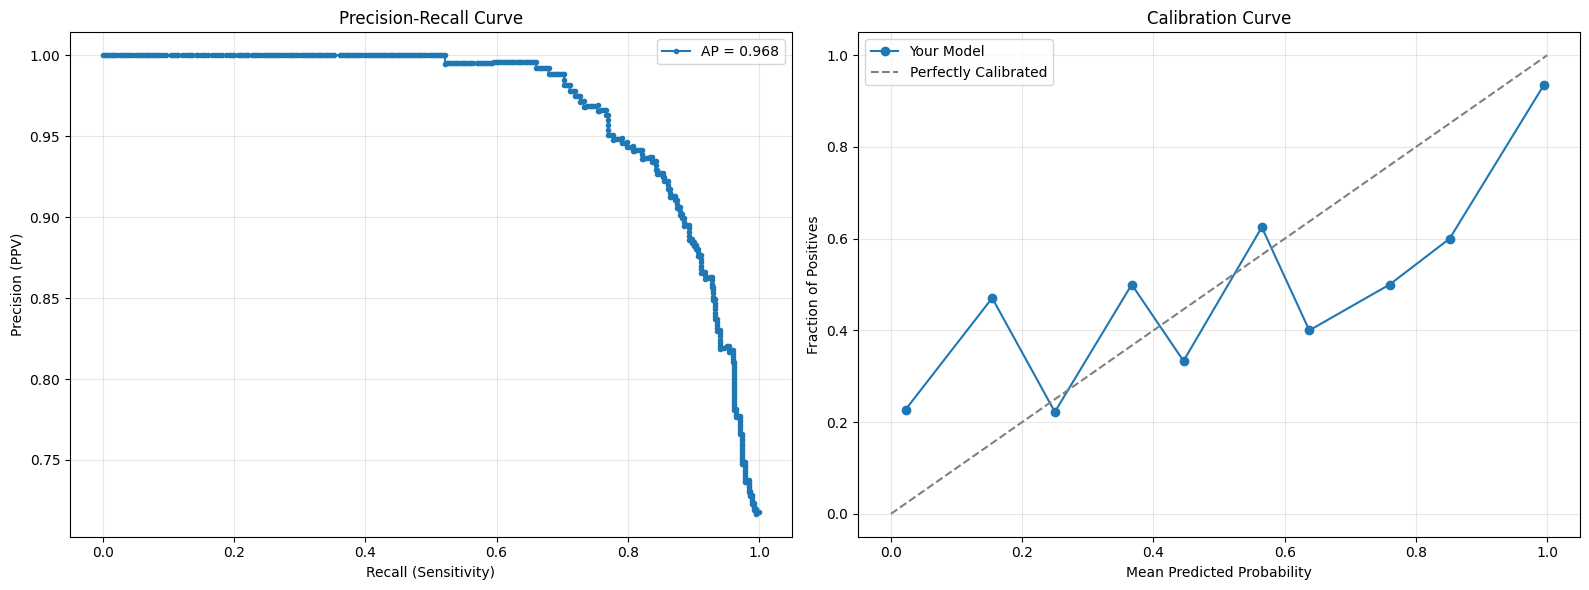


📸 RANDOM SAMPLE PREDICTIONS
• GREEN Title: The model was CORRECT.
• RED Title:   The model was WRONG.


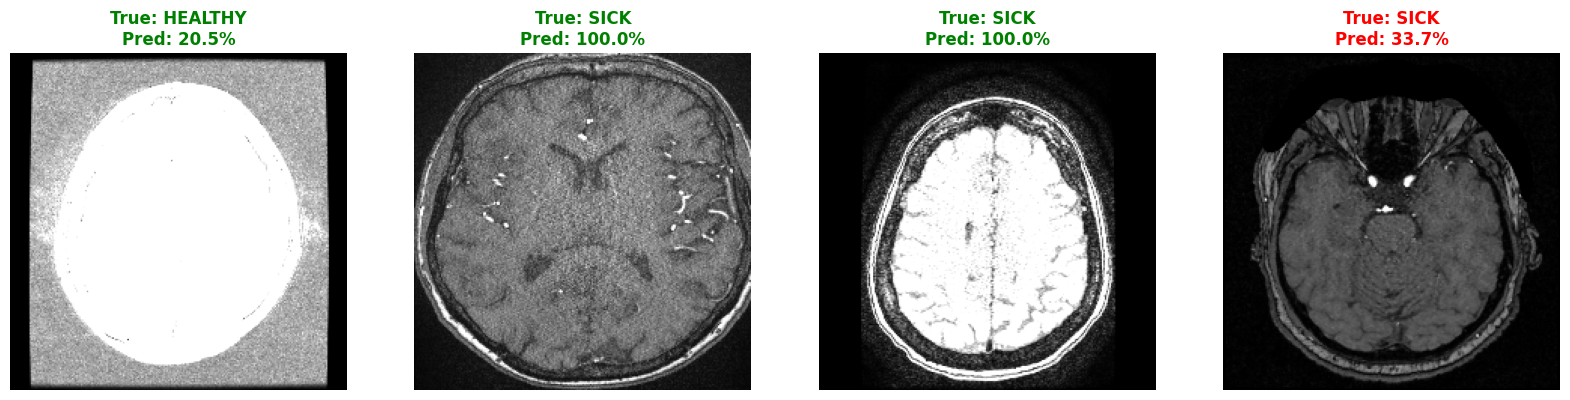

In [23]:
# FIX: calibration_curve is in sklearn.calibration
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import random

def advanced_model_diagnostics(model, loader, device=Config.DEVICE):
    model.eval()
    y_true, y_probs = [], []
    images = [] 
    
    print("🔬 Running Advanced Diagnostics (Collecting all test images)...")
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            
            # 1. Collect Data
            y_true.extend(y.cpu().numpy().flatten())
            y_probs.extend(probs)
            
            # 2. Collect Images for Visualization 
            # (We collect all to ensure true randomness)
            imgs = x.cpu().numpy()
            for i in range(len(imgs)):
                # Take middle slice (channel 1) for visualization
                img = imgs[i, 1, :, :] 
                images.append(img)
    
    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    images = np.array(images)
    
    # ==========================================
    # 1. PRECISION-RECALL CURVE
    # ==========================================
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ap_score = average_precision_score(y_true, y_probs)
    
    print("\n" + "="*60)
    print("📊 METRIC EXPLANATIONS")
    print("="*60)
    print(f"1. Precision-Recall (PR) Curve (AP = {ap_score:.3f})")
    print("   • Why it matters: PR curves are better than ROC for imbalanced data.")
    print("   • Interpretation: High AP (>0.90) means your model is excellent at finding")
    print("     RARE positive cases without drowning in false alarms.")
    
    # ==========================================
    # 2. CALIBRATION CURVE
    # ==========================================
    prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
    
    print("\n2. Calibration Curve")
    print("   • Why it matters: Tells us if the 'probability' (e.g. 80%) is real.")
    print("   • Interpretation:")
    print("     - Perfect: Dots hug the dashed gray line.")
    print("     - S-Shape / Below Line: The model is 'Overconfident' (Panic).")
    print("     - Above Line: The model is 'Underconfident' (Hesitant).")
    
    # PLOT METRICS
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot PR Curve
    axes[0].plot(recall, precision, marker='.', label=f'AP = {ap_score:.3f}')
    axes[0].set_xlabel('Recall (Sensitivity)')
    axes[0].set_ylabel('Precision (PPV)')
    axes[0].set_title('Precision-Recall Curve')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Plot Calibration
    axes[1].plot(prob_pred, prob_true, marker='o', label='Your Model')
    axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    axes[1].set_xlabel('Mean Predicted Probability')
    axes[1].set_ylabel('Fraction of Positives')
    axes[1].set_title('Calibration Curve')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ==========================================
    # 3. RANDOM SAMPLE GALLERY
    # ==========================================
    print("\n" + "="*60)
    print("📸 RANDOM SAMPLE PREDICTIONS")
    print("="*60)
    print("• GREEN Title: The model was CORRECT.")
    print("• RED Title:   The model was WRONG.")
    
    if len(images) > 0:
        # Pick 4 random indices from the total set
        random_indices = random.sample(range(len(images)), min(4, len(images)))
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # If we have fewer than 4 images, ensure axes is iterable
        if len(random_indices) == 1: axes = [axes]
            
        for i, idx in enumerate(random_indices):
            ax = axes[i]
            img = images[idx]
            true_label = "SICK" if y_true[idx] == 1 else "HEALTHY"
            pred_prob = y_probs[idx]
            
            is_correct = (round(pred_prob) == y_true[idx])
            color = 'green' if is_correct else 'red'
            
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {true_label}\nPred: {pred_prob:.1%}", color=color, fontweight='bold')
            ax.axis('off')
        plt.show()

# Run it
if 'test_loader' in locals():
    advanced_model_diagnostics(model, test_loader)